In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import copy
%matplotlib inline

In [2]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  8560


In [3]:
coco_dataset = dset.CocoCaptions(
    root='inpainting/train2014',
    annFile='inpainting/annotations/captions_train2014.json',
    transform=transforms.ToTensor()
)

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!


In [4]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path='inpainting/train2014',
        dev_path='inpainting/val2014',
        train_annotation_path='inpainting/annotations/captions_train2014.json',
        dev_annotation_path='inpainting/annotations/captions_val2014.json',
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    def _get_real_and_fake_images(self):
        """Get real and fake images from path."""
        self.train_dataset = dset.CocoCaptions(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.ToTensor()
        )
        self.valid_dataset = dset.CocoCaptions(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.ToTensor()
        )
        
        print('Populating training images & captions ...')
        train_images = []
        train_captions = []
        
        # There appears to be one image missing for some weird reason.
        try:
            for img, captions in self.train_dataset:
                train_images.append(img)
                train_captions.append(captions)
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        print('Populating validation images ...')
        valid_images = torch.stack([x[0] for x in self.valid_dataset])
        valid_captions = [x[1] for x in self.valid_dataset]
        
        print('Cropping 32x32 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, 16:48, 16:48] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 32x32 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, 16:48, 16:48] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
        
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        
        return real_examples, real_examples[:, :, 16:48, 16:48], fake_examples

In [5]:
iterator = DataIterator()

Processing data ...
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!
Populating training images & captions ...
Populating validation images ...
Cropping 32x32 patch for training images ...
Cropping 32x32 patch for validation images ...


(-0.5, 63.5, 63.5, -0.5)

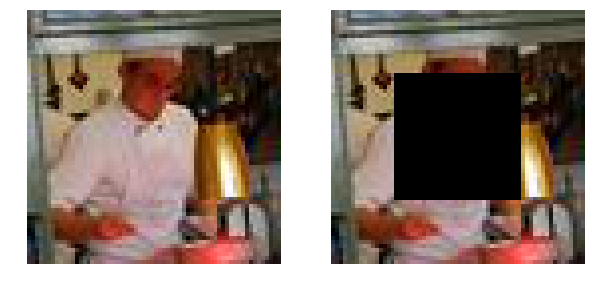

In [6]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[14].numpy().transpose(1, 2, 0))
plt.axis('off')

In [7]:
class UNetGenerator(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGenerator, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 128 x 4 x 4
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 64 x 8 x 8
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 3, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 2, out_channels=start_filter,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn3 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=start_filter, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        # Finally - 3 x 64 x 64

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv3 = F.relu(self.tbn3(self.tconv3(tconv2)))
        tconv4 = F.tanh(self.tconv4(tconv3))

        return tconv4

In [8]:
class UNetGeneratorSkip(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGeneratorSkip, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

        # 3 x 64 x 64
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 8 x 8
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        #################################
        ####### UPSAMPLER MODULE ########
        #################################

        # 64 x 4 x 4
        self.tconv1 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn1 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 8 x 8 + 48 x 8 x 8 = [96 x 8 x 8]
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=start_filter * 6, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.tbn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 16 x 16 + 32 x 16 x 16 = [64 x 16 x 16]
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=start_filter * 4, out_channels=3,
            kernel_size=4, stride=2, padding=1, bias=False
        )

    def forward(self, input):
        """Propogate input through the generator."""
        # Downsampling steps.
        conv1 = F.relu(self.bn1(self.conv1(input)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))

        # Upsampling steps.
        tconv1 = F.relu(self.tbn1(self.tconv1(conv4)))
        tconv1 = torch.cat((tconv1, conv3), 1)

        tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)))
        tconv2 = torch.cat((tconv2, conv2), 1)

        tconv3 = F.sigmoid(self.tconv3(tconv2))

        return tconv3

In [9]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()

        # 3 x 32 x 32
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=start_filter, kernel_size=4,
            stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(start_filter)

        # 16 x 16 x 16
        self.conv2 = nn.Conv2d(
            in_channels=start_filter, out_channels=start_filter * 2,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(start_filter * 2)

        # 32 x 8 x 8
        self.conv3 = nn.Conv2d(
            in_channels=start_filter * 2, out_channels=start_filter * 3,
            kernel_size=4, stride=2, padding=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(start_filter * 3)

        # 48 x 4 x 4
        self.conv4 = nn.Conv2d(
            in_channels=start_filter * 3, out_channels=start_filter * 4,
            kernel_size=4, stride=1, padding=1, bias=False
        )
        self.bn4 = nn.BatchNorm2d(start_filter * 4)

        # 64 x 2 x 2
        self.conv5 = nn.Conv2d(
            in_channels=start_filter * 4, out_channels=1,
            kernel_size=2, stride=2, padding=0, bias=False
        )

    def forward(self, input):
        """Propogate input through the network."""
        # Downsampling steps.
        # print 'input', input.size()
        conv1 = F.leaky_relu(self.bn1(self.conv1(input)))
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)))
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)))
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)))
        conv5 = self.conv5(conv4)

        return conv5.squeeze()

In [11]:
generator = UNetGeneratorSkip(start_filter=32).cuda()
discriminator = Discriminator(start_filter=32).cuda()
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
clamp_lower = -0.03
clamp_upper = 0.03
loss_criterion = nn.MSELoss().cuda()
save_dir = 'inpainting/jason_samples'

In [12]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    j = np.random.randint(low=0, high=500)
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 32)
    generator.eval()
    reconstructions = generator(fake_images)
    # fig = plt.figure(figsize=(20, 40))
    # idx = 1
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, 16:48, 16:48] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'inpainting/samples/epoch_%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()

In [ ]:
for i in range(15000):
    discriminator_losses = []
    generator_losses = []
    for j in range(0, iterator.num_train, 32):        
        ############################
        # (1) Update D network
        ############################
        
        for disc_updates in range(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 32)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            discriminator_loss = -.5 * ((D1 - D2).mean())
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()

            discriminator_losses.append(discriminator_loss.data[0])

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        generator_loss = -.5 * discriminator( generated_images).mean() + loss_criterion(generated_images, real_examples)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.data[0])

    print('[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses)))
    save_plots(i, fake_images, real_examples, real_examples_full)

/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0] Loss_D: -0.439292 Loss_G: 0.309692
[1] Loss_D: -0.402413 Loss_G: 0.334287
[2] Loss_D: -0.587064 Loss_G: 0.347931
[3] Loss_D: -0.600137 Loss_G: 0.344554
[4] Loss_D: -0.504697 Loss_G: 0.329279
[5] Loss_D: -0.601465 Loss_G: 0.351421
[6] Loss_D: -0.604272 Loss_G: 0.345129
[7] Loss_D: -0.605835 Loss_G: 0.342286
[8] Loss_D: -0.606709 Loss_G: 0.340411
[9] Loss_D: -0.607101 Loss_G: 0.338946
[10] Loss_D: -0.607223 Loss_G: 0.337726
[11] Loss_D: -0.607355 Loss_G: 0.336719
[12] Loss_D: -0.607470 Loss_G: 0.335347
[13] Loss_D: -0.607780 Loss_G: 0.335784
[14] Loss_D: -0.606452 Loss_G: 0.332856
[15] Loss_D: -0.607708 Loss_G: 0.332669
[16] Loss_D: -0.579303 Loss_G: 0.285913
[17] Loss_D: -0.211625 Loss_G: 0.126704
[18] Loss_D: -0.515363 Loss_G: 0.343041
[19] Loss_D: -0.434852 Loss_G: 0.328132
[20] Loss_D: -0.434897 Loss_G: 0.325758
[21] Loss_D: -0.483778 Loss_G: 0.330869
[22] Loss_D: -0.488898 Loss_G: 0.291170
[23] Loss_D: -0.352322 Loss_G: 0.234720
[24] Loss_D: -0.517652 Loss_G: 0.330959
[25] Loss_

[203] Loss_D: -0.578487 Loss_G: 0.314260
[204] Loss_D: -0.576656 Loss_G: 0.314645
[205] Loss_D: -0.463501 Loss_G: 0.304598
[206] Loss_D: -0.530632 Loss_G: 0.309960
[207] Loss_D: -0.573249 Loss_G: 0.313398
[208] Loss_D: -0.576122 Loss_G: 0.313721
[209] Loss_D: -0.536862 Loss_G: 0.310037
[210] Loss_D: -0.573893 Loss_G: 0.313783
[211] Loss_D: -0.578308 Loss_G: 0.313925
[212] Loss_D: -0.493131 Loss_G: 0.307126
[213] Loss_D: -0.527047 Loss_G: 0.309467
[214] Loss_D: -0.557565 Loss_G: 0.310794
[215] Loss_D: -0.564889 Loss_G: 0.312131
[216] Loss_D: -0.562350 Loss_G: 0.311950
[217] Loss_D: -0.579202 Loss_G: 0.313134
[218] Loss_D: -0.576747 Loss_G: 0.312695
[219] Loss_D: -0.554081 Loss_G: 0.310203
[220] Loss_D: -0.552046 Loss_G: 0.309848
[221] Loss_D: -0.483680 Loss_G: 0.306011
[222] Loss_D: -0.511126 Loss_G: 0.307497
[223] Loss_D: -0.489172 Loss_G: 0.306691
[224] Loss_D: -0.495165 Loss_G: 0.306930
[225] Loss_D: -0.523762 Loss_G: 0.308347
[226] Loss_D: -0.558352 Loss_G: 0.311270
[227] Loss_D: -0

[403] Loss_D: -0.516943 Loss_G: 0.302589
[404] Loss_D: -0.543506 Loss_G: 0.304889
[405] Loss_D: -0.567989 Loss_G: 0.306410
[406] Loss_D: -0.501749 Loss_G: 0.300703
[407] Loss_D: -0.483046 Loss_G: 0.301281
[408] Loss_D: -0.538681 Loss_G: 0.304140
[409] Loss_D: -0.565856 Loss_G: 0.306504
[410] Loss_D: -0.507673 Loss_G: 0.302110
[411] Loss_D: -0.530366 Loss_G: 0.304006
[412] Loss_D: -0.556304 Loss_G: 0.305252
[413] Loss_D: -0.486526 Loss_G: 0.299749
[414] Loss_D: -0.530934 Loss_G: 0.303299
[415] Loss_D: -0.565652 Loss_G: 0.306221
[416] Loss_D: -0.561381 Loss_G: 0.305742
[417] Loss_D: -0.507317 Loss_G: 0.300422
[418] Loss_D: -0.549623 Loss_G: 0.308589
[419] Loss_D: -0.482035 Loss_G: 0.301635
[420] Loss_D: -0.530459 Loss_G: 0.304841
[421] Loss_D: -0.562758 Loss_G: 0.306257
[422] Loss_D: -0.547161 Loss_G: 0.305067
[423] Loss_D: -0.529041 Loss_G: 0.303203
[424] Loss_D: -0.504052 Loss_G: 0.301982
[425] Loss_D: -0.546451 Loss_G: 0.303979
[426] Loss_D: -0.565852 Loss_G: 0.305775
[427] Loss_D: -0

[672] Loss_D: -0.579337 Loss_G: 0.309885
[673] Loss_D: -0.578144 Loss_G: 0.309854
[674] Loss_D: -0.579661 Loss_G: 0.310199
[675] Loss_D: -0.578741 Loss_G: 0.310031
[676] Loss_D: -0.583535 Loss_G: 0.310036
[677] Loss_D: -0.578273 Loss_G: 0.309816
[678] Loss_D: -0.581967 Loss_G: 0.310018
[679] Loss_D: -0.583889 Loss_G: 0.310046
[680] Loss_D: -0.406368 Loss_G: 0.280698
[681] Loss_D: -0.400936 Loss_G: 0.285995
[682] Loss_D: -0.453029 Loss_G: 0.298931
[683] Loss_D: -0.515773 Loss_G: 0.297539
[684] Loss_D: -0.507817 Loss_G: 0.299549
[685] Loss_D: -0.556501 Loss_G: 0.306757
[686] Loss_D: -0.543309 Loss_G: 0.303514
[687] Loss_D: -0.548975 Loss_G: 0.306367
[688] Loss_D: -0.553447 Loss_G: 0.306268
[689] Loss_D: -0.574132 Loss_G: 0.308477
[690] Loss_D: -0.579429 Loss_G: 0.308841
[691] Loss_D: -0.579855 Loss_G: 0.308942
[692] Loss_D: -0.571428 Loss_G: 0.307490
[693] Loss_D: -0.579830 Loss_G: 0.308761
[694] Loss_D: -0.579398 Loss_G: 0.308309
[695] Loss_D: -0.579433 Loss_G: 0.308686
[696] Loss_D: -0

[872] Loss_D: -0.556970 Loss_G: 0.302870
[873] Loss_D: -0.567877 Loss_G: 0.304488
[874] Loss_D: -0.570341 Loss_G: 0.304540
[875] Loss_D: -0.572849 Loss_G: 0.304646
[876] Loss_D: -0.570068 Loss_G: 0.304005
[877] Loss_D: -0.569282 Loss_G: 0.303791
[878] Loss_D: -0.478664 Loss_G: 0.293089
[879] Loss_D: -0.483798 Loss_G: 0.297089
[880] Loss_D: -0.542034 Loss_G: 0.301055
[881] Loss_D: -0.565554 Loss_G: 0.303345
[882] Loss_D: -0.568708 Loss_G: 0.303754
[883] Loss_D: -0.568594 Loss_G: 0.303143
[884] Loss_D: -0.568637 Loss_G: 0.303816
[885] Loss_D: -0.567208 Loss_G: 0.303955
[886] Loss_D: -0.570736 Loss_G: 0.302834
[887] Loss_D: -0.534919 Loss_G: 0.299094
[888] Loss_D: -0.491984 Loss_G: 0.295903
[889] Loss_D: -0.525916 Loss_G: 0.300240
[890] Loss_D: -0.565288 Loss_G: 0.302937
[891] Loss_D: -0.567513 Loss_G: 0.303773
[892] Loss_D: -0.560125 Loss_G: 0.302024
[893] Loss_D: -0.570829 Loss_G: 0.303766
[894] Loss_D: -0.572758 Loss_G: 0.304078
[895] Loss_D: -0.571692 Loss_G: 0.303778
[896] Loss_D: -0

[1071] Loss_D: -0.564804 Loss_G: 0.302422
[1072] Loss_D: -0.565748 Loss_G: 0.302229
[1073] Loss_D: -0.565558 Loss_G: 0.302557
[1074] Loss_D: -0.565355 Loss_G: 0.302640
[1075] Loss_D: -0.566302 Loss_G: 0.302372
[1076] Loss_D: -0.567263 Loss_G: 0.302476
[1077] Loss_D: -0.543825 Loss_G: 0.299105
[1078] Loss_D: -0.551444 Loss_G: 0.299636
[1079] Loss_D: -0.556509 Loss_G: 0.302520
[1080] Loss_D: -0.539926 Loss_G: 0.299620
[1081] Loss_D: -0.564571 Loss_G: 0.302727
[1082] Loss_D: -0.569614 Loss_G: 0.302768
[1083] Loss_D: -0.566064 Loss_G: 0.302442
[1084] Loss_D: -0.567014 Loss_G: 0.302973
[1085] Loss_D: -0.562664 Loss_G: 0.302195
[1086] Loss_D: -0.563287 Loss_G: 0.302088
[1087] Loss_D: -0.567134 Loss_G: 0.302479
[1088] Loss_D: -0.563982 Loss_G: 0.302591
[1089] Loss_D: -0.567999 Loss_G: 0.302553
[1090] Loss_D: -0.563079 Loss_G: 0.302057
[1091] Loss_D: -0.558223 Loss_G: 0.301690
[1092] Loss_D: -0.562772 Loss_G: 0.301763
[1093] Loss_D: -0.565823 Loss_G: 0.302775
[1094] Loss_D: -0.567556 Loss_G: 0

In [22]:
save_plots(i, fake_images, real_examples, real_examples_full)

In [27]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # Forward Pass
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()  
    
    # Backward Pass
    gradients_init = torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0])
    scores.backward(gradients_init)

    saliency = X.grad.data
    saliency = saliency.abs()
    saliency, i = torch.max(saliency, dim = 1)
    saliency = saliency.squeeze() 
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

TypeError: stack() missing 1 required positional arguments: "tensors"

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

In [ ]:
X_fooling_np = deprocess(fake_images.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(fake_images - real_examples, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (fake_images - real_examples), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

In [25]:
plt.imshow(real_examples[0].data.cpu().numpy().transpose(1, 2, 0))

IndexError: index 25 is out of bounds for dimension 0 with size 6

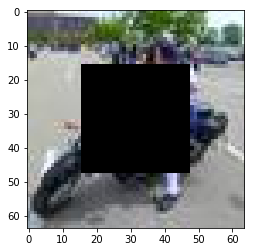

In [17]:
plt.imshow(fake_images[0].data.cpu().numpy().transpose(1, 2, 0))